In [2]:
# General libraries
import numpy as np
from scipy.stats import norm
import os

# Parallelisation libraries
from joblib import Parallel, delayed

# Module functions
# import ximinf.selection_effects as se
import ximinf.generate_sim as gsim
import ximinf.nn_inference as nninf
import ximinf.nn_test as nnte
import ximinf.nn_train as nntr

# Plot libraries
import matplotlib.pyplot as plt
import corner

from absl import logging
logging.set_verbosity(logging.ERROR)

In [3]:
num_threads = os.cpu_count()
print(f"Number of threads: {num_threads}")

Number of threads: 10


In [4]:
# -------- User parameters --------

N = 1 # Number of samples 100_000
M = 100 # Number of SNe per sample #3_000

# ---------------------------------

params = {
    'mabs': -19.3,
    'alpha_low': -0.271,
    'alpha_high': -0.083,
    'beta': 3.31,
    'gamma': 0.175,
    'sigma_int': 0.15,
}

columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'localcolor', 'localcolor_err', 'mass', 'mass_err', 'prompt', 'z']

n_realisation = 200

N_total = N*n_realisation

print("Running parallel simulations...")

results = Parallel(n_jobs=max(1,min(N_total//20, num_threads-2)))(
    delayed(gsim.simulate_one)(
        params,
        z_max=0.06,
        M=M,
        cols=columns,
        N=N_total,
        i=i
    )
    for i in range(N_total)
)


print("... done")

Running parallel simulations...
... doneon 200/200


In [5]:
# Jax libraries
import jax
import jax.numpy as jnp

In [7]:
# Try GPU backends in priority order
gpu = None
for backend in ("METAL", "cuda", "gpu"):
    try:
        devs = jax.devices(backend)
    except RuntimeError:
        continue
    if devs:
        gpu = devs[0]
        break

# Fallback
cpu = jax.devices("cpu")[0]

# Use GPU if found
if gpu=='cuda':
    nntr.print_gpu_memory()
    device = gpu 
elif gpu is not None:
    device = gpu
else:
    device = cpu
    
jax.default_device(device)
    

backend = jax.default_backend()
print(backend)

METAL


In [8]:
key = jax.random.PRNGKey(42)

In [9]:
data_dict = {col: np.zeros((N_total, M), dtype=np.float32) for col in columns}

for i, sim_data in enumerate(results):  # sim_data is just the dict returned by simulate_one
    for col, arr in sim_data.items():   # arr is a list of length M
        data_dict[col][i, :] = arr   # fill row i

## Load NN

In [13]:
# Parameters
models_per_group, models_config = nninf.load_autoregressive_nn('./data/NNs/nn_model_mac_m1_M100_z_0_06')

In [14]:
z = data_dict['z']
magobs = data_dict["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

In [15]:
# Take care to not run the correction twice
mu_planck18, magobs_corr = nntr.rm_cosmo(z, magobs)

data_dict['magobs'] = magobs_corr

In [16]:
# Make a copy to avoid in-place modification
columns_select = ['magobs', 'magobs_err', 'c', 'c_err','x1', 'x1_err', 'localcolor', 'localcolor_err']
data_norm = {k: data_dict[k].copy() for k in columns_select}

data_stats = models_config['shared']['data_stats']

for col, arr in data_norm.items():
    mu = data_stats[col]['mu']
    sigma = data_stats[col]['sigma']

    if col == 'magobs':
        # mask zeros
        mask = arr != 0.0
        data_norm[col] = arr.at[mask].set((arr[mask] - mu) / sigma)
    else:
        data_norm[col] = (arr - mu) / sigma

In [17]:
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

global_param_names = models_config['shared']['global_param_names']
print(f"Parameters : {global_param_names}")

param_groups = models_config['shared']['param_groups']

Parameters : ['mabs', 'beta', 'alpha_low', 'alpha_high', 'gamma', 'sigma_int']


In [18]:
# ========== Set priors ========== (In alphabetical order ?)
BOUNDS = jnp.array([
    [models_config['shared']['bounds'][p]['min'], models_config['shared']['bounds'][p]['max']]
    for p in global_param_names
])

BOUNDS_norm = jnp.array([
    [models_config['shared']['bounds_norm'][p]['min'], models_config['shared']['bounds_norm'][p]['max']]
    for p in global_param_names
])

In [19]:
param_stats = models_config['shared']['param_stats']
theta_init = jnp.asarray([-19.35+19.3, 3.2, -0.3, -0.1, 0.15, 0.15])
theta_init_dict = {name: theta_init[i] for i, name in enumerate(global_param_names)}
theta_init_normed_dict = nntr.normalize(theta_init_dict, param_stats)
theta_init_normed = jnp.array([theta_init_normed_dict[name] for name in global_param_names])

In [20]:
# Convert each column to a 1D array and concatenate into shape (M*C,)
# Prepare inference arrays
data_arrays = [data_norm[col] for col in columns_select]  # list of (M,)
n_cols = len(columns_select)

# Stack along last axis to get shape (M, n_cols)
data_stacked = jnp.stack(jnp.asarray(data_arrays), axis=-1)  

# Flatten and add batch dimension: (1, M * n_cols)
data_concat_infer = data_stacked.reshape(N_total, M * n_cols)

# Concatenate features + mask
inputs_infer = jnp.concatenate([data_concat_infer, jnp.asarray(mask).reshape(N_total,M)], axis=-1)

print(inputs_infer.shape)

(200, 900)


In [21]:
# ========== MCMC Sampling ==========

# ----------------------------
# Precompute parameter indices
# ----------------------------
visible_indices, group_indices = nnte.preprocess_groups(param_groups, global_param_names)

n_pull = min(200, N_total)

n_points = 100
post_pull = jnp.zeros((n_pull, n_points, len(global_param_names)))

print("Launch MCMCs ...")
for i in range(n_pull):
    print(f'Sample {i+1}/{n_pull}', end='\r')

    def log_post(theta):
        # Use the new grouped log-prob function
        return nnte.log_prob_fn_groups(
            theta,
            models_per_group,  # list of models per group
            inputs_infer[i,:],
            BOUNDS_norm,
            visible_indices,
            group_indices
        )
    
    # Run MCMC
    
    key, samples = nnte.sample_posterior(
        log_post,
        n_warmup=100,
        n_samples=n_points,
        init_position=theta_init_normed,
        rng_key=key
    )

    post_pull = post_pull.at[i, :, :].set(samples)
    
print("...finished")

Launch MCMCs ...


XlaRuntimeError: UNKNOWN: /Users/atrigui/miniconda3/envs/sbi_conda/lib/python3.12/site-packages/ximinf/nn_test.py:93:32: error: failed to legalize operation 'mhlo.popcnt'
    (warmup_state, params), _ = warmup.run(warmup_key, init_position, num_steps=n_warmup)
                               ^
/Users/atrigui/miniconda3/envs/sbi_conda/lib/python3.12/site-packages/ximinf/nn_test.py:93:32: note: called from
    (warmup_state, params), _ = warmup.run(warmup_key, init_position, num_steps=n_warmup)
                               ^
/Users/atrigui/miniconda3/envs/sbi_conda/lib/python3.12/site-packages/ximinf/nn_test.py:100:36: note: called from
    rng_key, kernel, warmup_state = build_kernel(log_prob, init_position, n_warmup, rng_key)
                                   ^
/var/folders/98/9tmsfpws669458831tkwxxbr0000gp/T/ipykernel_99209/2837779387.py:30:19: note: called from
<frozen runpy>:88:4: note: called from
<frozen runpy>:198:11: note: called from
/Users/atrigui/miniconda3/envs/sbi_conda/lib/python3.12/site-packages/ximinf/nn_test.py:93:32: note: see current operation: %8438 = "mhlo.popcnt"(%8437) : (tensor<si32>) -> tensor<si32>
    (warmup_state, params), _ = warmup.run(warmup_key, init_position, num_steps=n_warmup)
                               ^


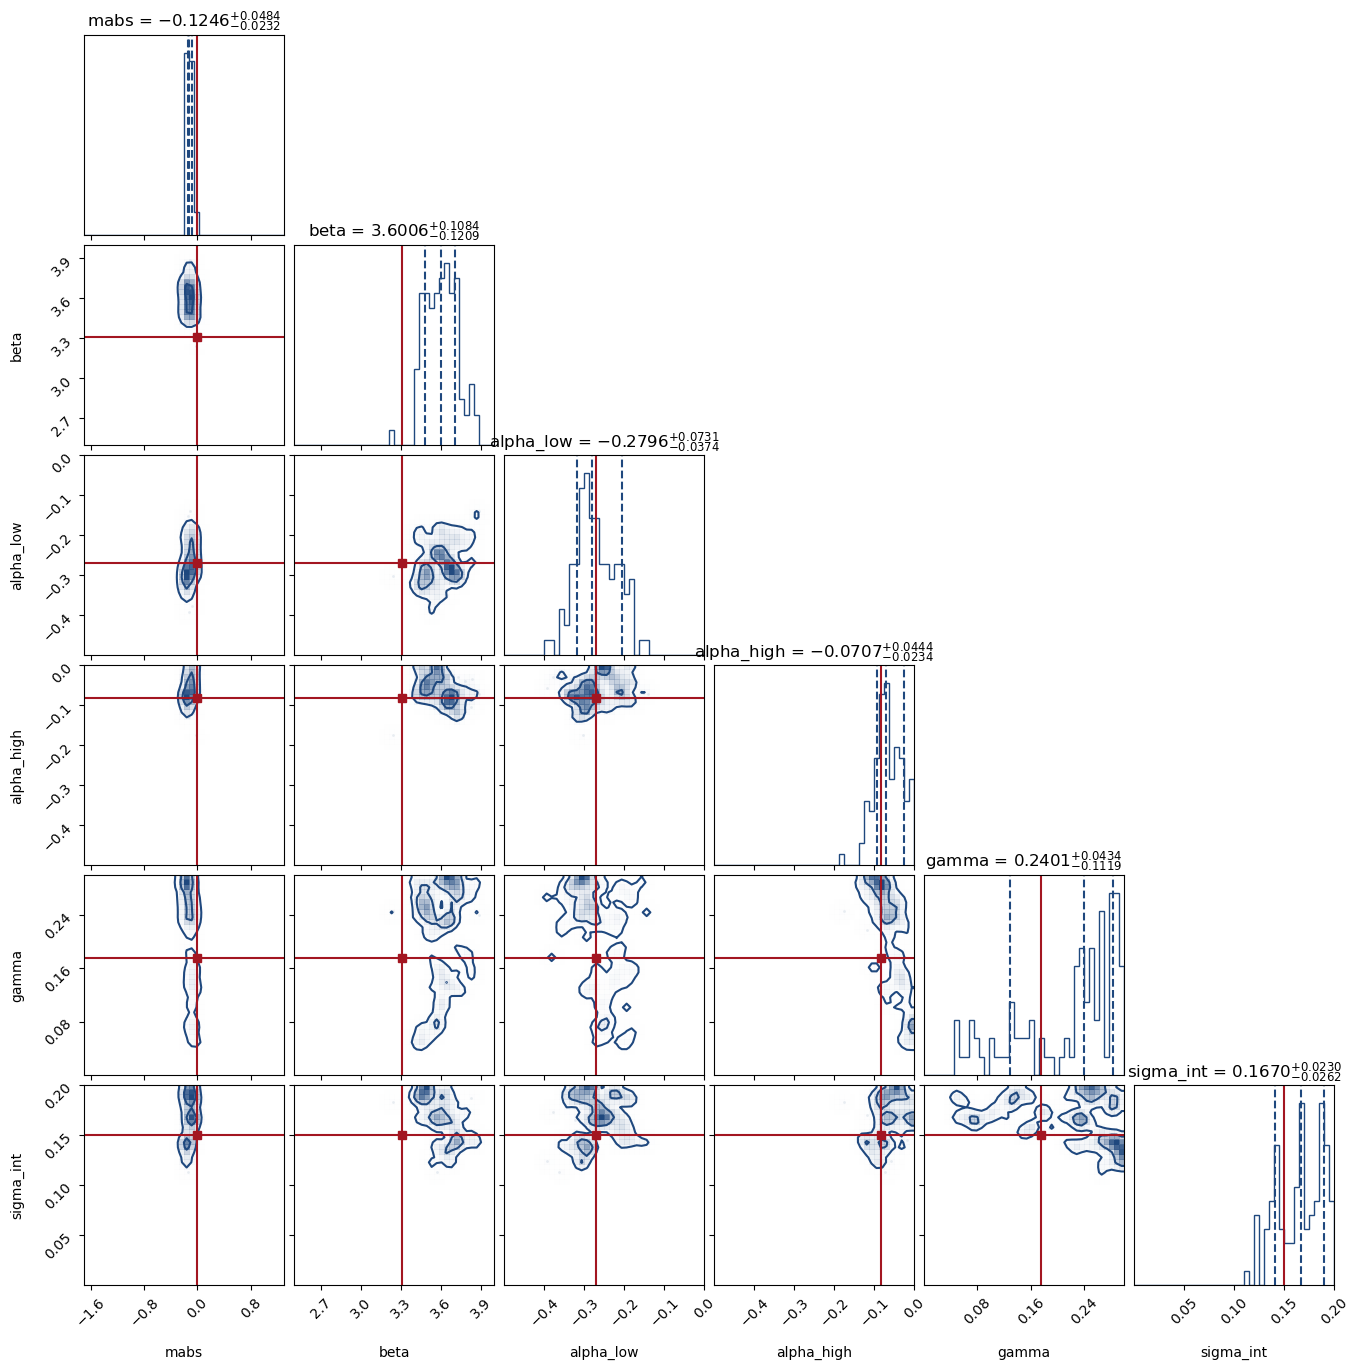

In [17]:
truths = np.array([params[name] for name in global_param_names])
truths[0]+=19.3
post = post_pull[0,:,:]

# post has shape (n_samples, n_params)
n_points, n_params = post.shape

# Convert post from array to dict with column names
post_dict = {name: post[:, i] for i, name in enumerate(global_param_names)}

# Unnormalize each parameter
post_unnormed_dict = nntr.unnormalize(post_dict, param_stats)

# Convert back to array for plotting
post_unnormed = jnp.stack([post_unnormed_dict[name] for name in global_param_names], axis=1)

# Now post_unnormed[:, i] contains the real-scale parameters
x = post_unnormed[:, 0]

fig = corner.corner(
    np.array(post_unnormed),
    labels=global_param_names,
    range=[tuple(b) for b in BOUNDS],
    truths=truths,
    quantiles=[0.16, 0.5, 0.84],      # 1D marginal: 1σ
    levels=[0.393469, 0.864665],     # 2D contours: 1σ, 2σ
    show_titles=True,
    title_fmt=".4f",
    bins=40,
    smooth=1.0,
    color="#1F487E",
    truth_color="#A31621", 
    truth_alpha=0.8
)

plt.savefig("./corner.png",dpi=150)
plt.show()

In [18]:
post_pull_unnormed = []

for c in range(n_pull):
    post = post_pull[c]  # (n_samples, n_params)

    post_dict = {
        name: post[:, i]
        for i, name in enumerate(global_param_names)
    }

    post_unnormed_dict = nntr.unnormalize(post_dict, param_stats)

    post_unnormed = jnp.stack(
        [post_unnormed_dict[name] for name in global_param_names],
        axis=1
    )

    post_pull_unnormed.append(post_unnormed)

post_pull_unnormed = jnp.stack(post_pull_unnormed, axis=0)


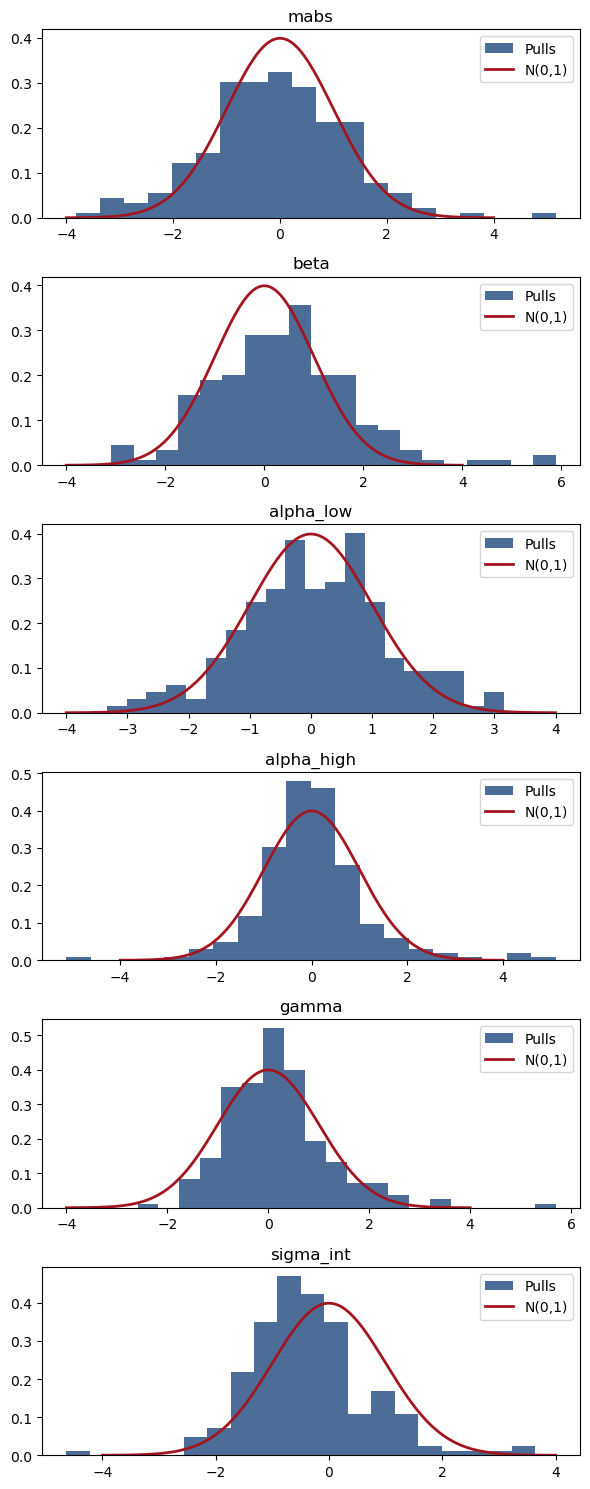

In [20]:
post_pull_mean = jnp.mean(post_pull_unnormed, axis=1)
post_pull_std = jnp.std(post_pull_unnormed, axis=1)
pull = (post_pull_mean - truths)/post_pull_std

fig, axes = plt.subplots(
    n_params,
    1,
    figsize=(6, 2.5 * n_params),
    sharex=False,
)

# Make axes iterable even if n_params == 1
axes = np.atleast_1d(axes)

for i, ax in enumerate(axes):
    # Histogram of pulls
    ax.hist(
        pull[:, i],
        bins=20,
        density=True,
        color="#1F487E",
        alpha=0.8,
        label="Pulls",
    )

    # Standard normal curve
    x = np.linspace(-4, 4, 200)
    pdf = norm.pdf(x, loc=0, scale=1)
    ax.plot(x, pdf, color="#A31621", linewidth=2, label="N(0,1)")

    ax.set_title(global_param_names[i])
    ax.legend()

plt.tight_layout()
plt.savefig('pull.png', dpi=150)
plt.show()


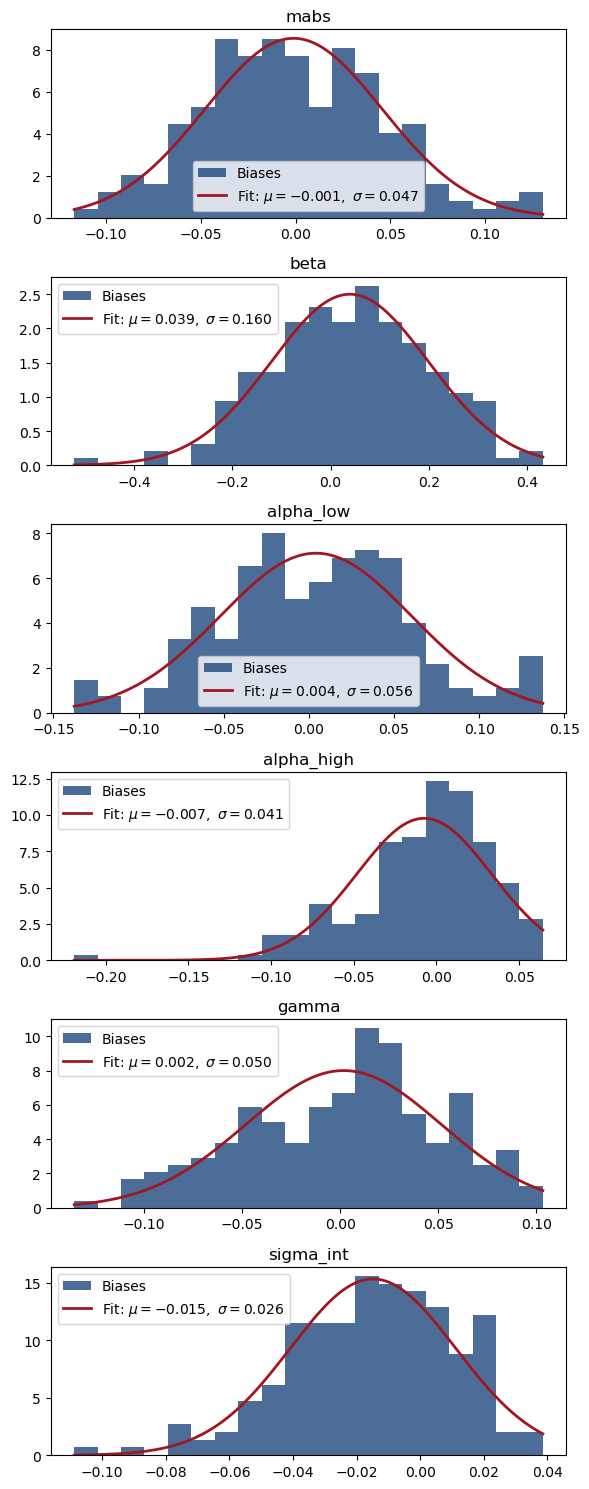

In [21]:
bias = (post_pull_mean - truths)

fig, axes = plt.subplots(
    n_params,
    1,
    figsize=(6, 2.5 * n_params),
    sharex=False,
)

# Make axes iterable even if n_params == 1
axes = np.atleast_1d(axes)

for i, ax in enumerate(axes):
    # Histogram of pulls
    ax.hist(
        bias[:, i],
        bins=20,
        density=True,
        color="#1F487E",
        alpha=0.8,
        label="Biases",
    )

    # Fit Gaussian to samples
    mu_hat, sigma_hat = norm.fit(bias[:, i])

    # Plot fitted Gaussian
    x = np.linspace(bias[:, i].min(), bias[:, i].max(), 400)
    pdf_fit = norm.pdf(x, loc=mu_hat, scale=sigma_hat)
    ax.plot(
        x,
        pdf_fit,
        color="#A31621",
        linewidth=2,
        label=fr"Fit: $\mu={mu_hat:.3f},\ \sigma={sigma_hat:.3f}$",
    )

    ax.set_title(global_param_names[i])
    ax.legend()

plt.tight_layout()
plt.savefig('bias.png', dpi=150)
plt.show()
